In [1]:
# Investment Portfolio Tracker - Jupyter Notebook
# Portfolio med startdato, indskud og daglig tracking
# Base Currency: DKK

# Cell 1: Import Libraries
import pandas as pd
import yfinance as yf
import requests
from datetime import datetime, timedelta
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


In [2]:
# Cell 2: Configuration
TRANSACTIONS_FILE = 'transactions.csv'
PORTFOLIO_CONFIG_FILE = 'portfolio_config.csv'
BASE_CURRENCY = 'DKK'

print(f"Portfolio Configuration:")
print(f"  Transactions File: {TRANSACTIONS_FILE}")
print(f"  Portfolio Config File: {PORTFOLIO_CONFIG_FILE}")
print(f"  Base Currency: {BASE_CURRENCY}")

Portfolio Configuration:
  Transactions File: transactions.csv
  Portfolio Config File: portfolio_config.csv
  Base Currency: DKK


In [3]:
# Cell 3: Helper Functions
def load_portfolio_config():
    """Load portfolio configuration (start date and initial deposit)"""
    if os.path.exists(PORTFOLIO_CONFIG_FILE):
        df = pd.read_csv(PORTFOLIO_CONFIG_FILE)
        config = df.iloc[0].to_dict()
        print(f"✓ Loaded portfolio config: Start date: {config['start_date']}, Initial deposit: {config['initial_deposit']} {config['currency']}")
        return config
    else:
        print("ℹ No portfolio config found. Please create one using Cell 4.")
        return None

def save_portfolio_config(start_date, initial_deposit, currency=BASE_CURRENCY):
    """Save portfolio configuration"""
    config_df = pd.DataFrame({
        'start_date': [start_date],
        'initial_deposit': [initial_deposit],
        'currency': [currency]
    })
    config_df.to_csv(PORTFOLIO_CONFIG_FILE, index=False)
    print(f"✓ Portfolio config saved: Start {start_date}, Deposit {initial_deposit} {currency}")

def load_transactions():
    """Load transactions from CSV file"""
    if os.path.exists(TRANSACTIONS_FILE):
        df = pd.read_csv(TRANSACTIONS_FILE)
        print(f"✓ Loaded {len(df)} transactions from {TRANSACTIONS_FILE}")
        return df
    else:
        print(f"ℹ No existing transactions file. Creating new one.")
        return pd.DataFrame(columns=['date', 'ticker', 'action', 'quantity', 'price', 'currency', 'dividend_amount'])

def save_transactions(df):
    """Save transactions to CSV file"""
    df.to_csv(TRANSACTIONS_FILE, index=False)
    print(f"✓ Saved {len(df)} transactions to {TRANSACTIONS_FILE}")

def get_exchange_rate(from_currency, to_currency=BASE_CURRENCY):
    """Get exchange rate from currency to base currency"""
    if from_currency == to_currency:
        return 1.0
    
    try:
        url = f"https://api.exchangerate-api.com/v4/latest/{from_currency}"
        response = requests.get(url, timeout=5)
        data = response.json()
        return data['rates'].get(to_currency, 1.0)
    except Exception as e:
        fallback_rates = {'USD': 7.0, 'EUR': 7.45, 'GBP': 8.7, 'DKK': 1.0}
        return fallback_rates.get(from_currency, 1.0)

def get_current_prices(tickers):
    """Fetch current prices for list of tickers"""
    prices = {}
    for ticker in tickers:
        try:
            stock = yf.Ticker(ticker)
            hist = stock.history(period='1d')
            if not hist.empty:
                prices[ticker] = hist['Close'].iloc[-1]
                print(f"  ✓ {ticker}: {prices[ticker]:.2f}")
            else:
                prices[ticker] = None
        except Exception as e:
            print(f"  ✗ Error fetching {ticker}: {e}")
            prices[ticker] = None
    return prices

def get_historical_prices(tickers, start_date):
    """Fetch historical prices for tickers from start_date to today"""
    all_prices = {}
    
    for ticker in tickers:
        try:
            stock = yf.Ticker(ticker)
            hist = stock.history(start=start_date)
            if not hist.empty:
                all_prices[ticker] = hist['Close']
                print(f"  ✓ {ticker}: {len(hist)} days of data")
            else:
                print(f"  ⚠ No historical data for {ticker}")
                all_prices[ticker] = None
        except Exception as e:
            print(f"  ✗ Error fetching {ticker}: {e}")
            all_prices[ticker] = None
    
    return all_prices

def calculate_cash_balance(transactions, portfolio_config):
    """Calculate current cash balance from deposits and transactions"""
    if portfolio_config is None:
        return 0
    
    # Start with initial deposit
    rate = get_exchange_rate(portfolio_config['currency'])
    cash_balance = portfolio_config['initial_deposit'] * rate
    
    # Process all transactions
    for _, row in transactions.iterrows():
        trans_rate = get_exchange_rate(row['currency'])
        
        if row['action'] == 'buy':
            # Buying reduces cash
            cash_balance -= row['quantity'] * row['price'] * trans_rate
        elif row['action'] == 'sell':
            # Selling increases cash
            cash_balance += row['quantity'] * row['price'] * trans_rate
        elif row['action'] == 'dividend':
            # Dividends increase cash
            dividend_amt = row.get('dividend_amount', 0)
            if pd.notna(dividend_amt):
                cash_balance += dividend_amt * trans_rate
    
    return cash_balance

def calculate_holdings_at_date(transactions, target_date):
    """Calculate holdings at a specific date"""
    holdings = {}
    
    transactions_to_date = transactions[pd.to_datetime(transactions['date']) <= pd.to_datetime(target_date)]
    
    for _, row in transactions_to_date.iterrows():
        if row['action'] in ['buy', 'sell']:
            ticker = row['ticker']
            if ticker not in holdings:
                holdings[ticker] = {
                    'quantity': 0,
                    'total_cost': 0,
                    'currency': row['currency']
                }
            
            if row['action'] == 'buy':
                holdings[ticker]['quantity'] += row['quantity']
                holdings[ticker]['total_cost'] += row['quantity'] * row['price']
            elif row['action'] == 'sell':
                holdings[ticker]['quantity'] -= row['quantity']
                holdings[ticker]['total_cost'] -= row['quantity'] * row['price']
    
    # Remove stocks with 0 or negative quantity
    holdings = {k: v for k, v in holdings.items() if v['quantity'] > 0}
    return holdings

print("✓ Helper functions defined")


✓ Helper functions defined


In [4]:
# Cell 4: Create New Portfolio
# RUN THIS CELL ONCE to create a new portfolio
# Modify these values before running:

start_date = "2025-01-01"  # Start date for portfolio (YYYY-MM-DD)
initial_deposit = 1000000   # Initial deposit amount
currency = "DKK"           # Currency of initial deposit

save_portfolio_config(start_date, initial_deposit, currency)
print(f"\n✓ Portfolio created!")
print(f"  Start Date: {start_date}")
print(f"  Initial Deposit: {initial_deposit} {currency}")

✓ Portfolio config saved: Start 2025-01-01, Deposit 1000000 DKK

✓ Portfolio created!
  Start Date: 2025-01-01
  Initial Deposit: 1000000 DKK


In [4]:
# Cell 5: Load Portfolio Configuration
portfolio_config = load_portfolio_config()

if portfolio_config:
    print(f"\n📊 Current Portfolio Configuration:")
    print(f"  Start Date: {portfolio_config['start_date']}")
    print(f"  Initial Deposit: {portfolio_config['initial_deposit']} {portfolio_config['currency']}")
    
    # Calculate in DKK
    rate = get_exchange_rate(portfolio_config['currency'])
    initial_in_dkk = portfolio_config['initial_deposit'] * rate
    print(f"  Initial Deposit in {BASE_CURRENCY}: {initial_in_dkk:,.2f}")

✓ Loaded portfolio config: Start date: 2025-01-01, Initial deposit: 1000000 DKK

📊 Current Portfolio Configuration:
  Start Date: 2025-01-01
  Initial Deposit: 1000000 DKK
  Initial Deposit in DKK: 1,000,000.00


In [5]:
# Cell 6: Load Transactions
transactions = load_transactions()

if not transactions.empty:
    print(f"\n✓ Loaded {len(transactions)} transactions")
    print("\nLatest transactions:")
    display(transactions.tail())
else:
    print("\nNo transactions yet. Use the cells below to add some!")

✓ Loaded 2 transactions from transactions.csv

✓ Loaded 2 transactions

Latest transactions:


,date,ticker,action,quantity,price,currency,dividend_amount
0,2025-06-25,AAPL,buy,100.0,243.0,USD,NaN
1,2025-07-10,MSFT,buy,10.0,150.0,USD,NaN


In [ ]:
# Cell 7: Add BUY Transaction
# Modify these values and run the cell to add a BUY transaction

ticker = "MSFT"  # Stock ticker symbol
quantity = 10     # Number of shares
price = 150.00    # Price per share
currency = "USD"  # Currency (USD, EUR, GBP, DKK)
#date = datetime.now().strftime('%Y-%m-%d')  # Leave as is for today, or use 'YYYY-MM-DD'
date = '2025-07-10'

# Add transaction
new_transaction = pd.DataFrame({
    'date': [date],
    'ticker': [ticker.upper()],
    'action': ['buy'],
    'quantity': [float(quantity)],
    'price': [float(price)],
    'currency': [currency.upper()],
    'dividend_amount': [None]
})

transactions = pd.concat([transactions, new_transaction], ignore_index=True)
save_transactions(transactions)

print(f"✓ Added BUY: {quantity} shares of {ticker.upper()} at {price} {currency}")
print(f"Total transactions: {len(transactions)}")

# Calculate and show remaining cash
cash_balance = calculate_cash_balance(transactions, portfolio_config)
print(f"💰 Remaining cash: {cash_balance:,.2f} {BASE_CURRENCY}")


✓ Saved 2 transactions to transactions.csv
✓ Added BUY: 10 shares of NVIDIA at 150.0 USD
Total transactions: 2
💰 Remaining cash: 834,364.00 DKK


In [ ]:
# Cell 8: Add SELL Transaction
# Modify these values and run the cell to add a SELL transaction

ticker = "AAPL"  # Stock ticker symbol
quantity = 5      # Number of shares
price = 160.00    # Price per share
currency = "USD"  # Currency (USD, EUR, GBP, DKK)
date = datetime.now().strftime('%Y-%m-%d')  # Leave as is for today, or use 'YYYY-MM-DD'

# Add transaction
new_transaction = pd.DataFrame({
    'date': [date],
    'ticker': [ticker.upper()],
    'action': ['sell'],
    'quantity': [float(quantity)],
    'price': [float(price)],
    'currency': [currency.upper()],
    'dividend_amount': [None]
})

transactions = pd.concat([transactions, new_transaction], ignore_index=True)
save_transactions(transactions)

print(f"✓ Added SELL: {quantity} shares of {ticker.upper()} at {price} {currency}")
print(f"Total transactions: {len(transactions)}")

# Calculate and show remaining cash
cash_balance = calculate_cash_balance(transactions, portfolio_config)
print(f"💰 Remaining cash: {cash_balance:,.2f} {BASE_CURRENCY}")


In [ ]:
# Cell 9: Add DIVIDEND (Aktieudbytte)
# Modify these values and run the cell to add a DIVIDEND transaction

ticker = "AAPL"       # Stock ticker symbol
dividend_amount = 25.50  # Total dividend received (in the specified currency)
currency = "USD"      # Currency (USD, EUR, GBP, DKK)
date = datetime.now().strftime('%Y-%m-%d')  # Leave as is for today, or use 'YYYY-MM-DD'

# Add dividend transaction
new_transaction = pd.DataFrame({
    'date': [date],
    'ticker': [ticker.upper()],
    'action': ['dividend'],
    'quantity': [0],
    'price': [0],
    'currency': [currency.upper()],
    'dividend_amount': [float(dividend_amount)]
})

transactions = pd.concat([transactions, new_transaction], ignore_index=True)
save_transactions(transactions)

print(f"✓ Added DIVIDEND: {dividend_amount} {currency} from {ticker.upper()}")
print(f"Total transactions: {len(transactions)}")

# Calculate and show remaining cash
cash_balance = calculate_cash_balance(transactions, portfolio_config)
print(f"💰 Cash balance (including dividend): {cash_balance:,.2f} {BASE_CURRENCY}")


In [11]:
# Cell 10: View All Transactions
from jinja2 import Environment, PackageLoader
transactions_sorted = transactions.sort_values('date', ascending=False)
print(f"Transaction History ({len(transactions)} total)\n")
display(transactions_sorted)

# Cell 11: Current Portfolio Status
if portfolio_config is None:
    print("Please create a portfolio configuration first (Cell 4)")
else:
    print("Fetching current prices...")
    
    # Get current holdings
    holdings = calculate_holdings_at_date(transactions, datetime.now().strftime('%Y-%m-%d'))
    
    if not holdings:
        cash_balance = calculate_cash_balance(transactions, portfolio_config)
        print(f"\nPortfolio Status:")
        print(f"  No stock holdings")
        print(f"  Cash: {cash_balance:,.2f} {BASE_CURRENCY}")
        print(f"  Total Portfolio Value: {cash_balance:,.2f} {BASE_CURRENCY}")
    else:
        tickers = list(holdings.keys())
        prices = get_current_prices(tickers)
        
        print(f"\n{'='*100}")
        print(f"CURRENT PORTFOLIO STATUS (in {BASE_CURRENCY})")
        print(f"{'='*100}\n")
        
        # Calculate portfolio
        portfolio_data = []
        total_stock_value_dkk = 0
        total_dividends_dkk = 0
        
        # Calculate total dividends
        dividend_transactions = transactions[transactions['action'] == 'dividend']
        for _, row in dividend_transactions.iterrows():
            dividend_amt = row.get('dividend_amount', 0)
            if pd.notna(dividend_amt):
                rate = get_exchange_rate(row['currency'])
                total_dividends_dkk += dividend_amt * rate
        
        for ticker, holding in holdings.items():
            quantity = holding['quantity']
            total_cost = holding['total_cost']
            avg_cost = total_cost / quantity
            currency = holding['currency']
            
            rate = get_exchange_rate(currency)
            cost_dkk = total_cost * rate
            
            current_price = prices.get(ticker)
            if current_price:
                value_original = quantity * current_price
                value_dkk = value_original * rate
                total_stock_value_dkk += value_dkk
                
                gain_loss = value_dkk - cost_dkk
                gain_loss_pct = (gain_loss / cost_dkk * 100) if cost_dkk > 0 else 0
                
                portfolio_data.append({
                    'Ticker': ticker,
                    'Quantity': quantity,
                    f'Avg Cost ({currency})': avg_cost,
                    f'Current ({currency})': current_price,
                    f'Value ({BASE_CURRENCY})': value_dkk,
                    f'Gain/Loss ({BASE_CURRENCY})': gain_loss,
                    'Gain/Loss %': gain_loss_pct
                })
        
        if portfolio_data:
            portfolio_df = pd.DataFrame(portfolio_data)
            
            def color_gain_loss(val):
                if isinstance(val, (int, float)):
                    color = 'green' if val >= 0 else 'red'
                    return f'color: {color}'
                return ''
            
            styled_df = portfolio_df.style.applymap(
                color_gain_loss, 
                subset=['Gain/Loss %', f'Gain/Loss ({BASE_CURRENCY})']
            ).format({
                'Quantity': '{:.2f}',
                f'Avg Cost ({currency})': '{:.2f}',
                f'Current ({currency})': '{:.2f}',
                f'Value ({BASE_CURRENCY})': '{:,.2f}',
                f'Gain/Loss ({BASE_CURRENCY})': '{:+,.2f}',
                'Gain/Loss %': '{:+.2f}%'
            })
            
            display(styled_df)
        
        # Calculate cash and totals
        cash_balance = calculate_cash_balance(transactions, portfolio_config)
        total_portfolio_value = total_stock_value_dkk + cash_balance
        
        # Calculate initial deposit in DKK
        rate = get_exchange_rate(portfolio_config['currency'])
        initial_deposit_dkk = portfolio_config['initial_deposit'] * rate
        
        total_return = total_portfolio_value - initial_deposit_dkk
        total_return_pct = (total_return / initial_deposit_dkk * 100) if initial_deposit_dkk > 0 else 0
        
        print(f"\n{'='*100}")
        print(f"Stock Holdings Value:     {total_stock_value_dkk:>15,.2f} {BASE_CURRENCY}")
        print(f"Cash Balance:             {cash_balance:>15,.2f} {BASE_CURRENCY}")
        print(f"Total Portfolio Value:    {total_portfolio_value:>15,.2f} {BASE_CURRENCY}")
        print(f"-" * 100)
        print(f"Initial Deposit:          {initial_deposit_dkk:>15,.2f} {BASE_CURRENCY}")
        print(f"Total Dividends Received: {total_dividends_dkk:>15,.2f} {BASE_CURRENCY}")
        print(f"Total Return:             {total_return:>15,.2f} {BASE_CURRENCY} ({total_return_pct:+.2f}%)")
        print(f"{'='*100}")


Transaction History (2 total)



,date,ticker,action,quantity,price,currency,dividend_amount
1,2025-07-10,MSFT,buy,10.0,150.0,USD,NaN
0,2025-06-25,AAPL,buy,100.0,243.0,USD,NaN


Fetching current prices...
  ✓ AAPL: 273.74
  ✓ MSFT: 507.52

CURRENT PORTFOLIO STATUS (in DKK)



,Ticker,Quantity,Avg Cost (USD),Current (USD),Value (DKK),Gain/Loss (DKK),Gain/Loss %
0,AAPL,100.00,243.00,273.74,"175,741.07","+19,735.07",+12.65%
1,MSFT,10.00,150.00,507.52,"32,582.78","+22,952.78",+238.35%



Stock Holdings Value:          208,323.86 DKK
Cash Balance:                  834,364.00 DKK
Total Portfolio Value:       1,042,687.86 DKK
----------------------------------------------------------------------------------------------------
Initial Deposit:             1,000,000.00 DKK
Total Dividends Received:            0.00 DKK
Total Return:                   42,687.86 DKK (+4.27%)


Calculating daily portfolio development...
This may take a moment as we fetch historical prices...

Fetching historical prices...
  ✓ AAPL: 218 days of data
  ✓ MSFT: 218 days of data
2025-09-24 00:00:00-04:00
2025-06-25 00:00:00-04:00
2025-06-26 00:00:00-04:00
2025-06-27 00:00:00-04:00
2025-06-27 00:00:00-04:00
2025-06-27 00:00:00-04:00
2025-06-30 00:00:00-04:00
2025-07-01 00:00:00-04:00
2025-07-02 00:00:00-04:00
2025-07-03 00:00:00-04:00
2025-07-03 00:00:00-04:00
2025-07-03 00:00:00-04:00
2025-07-03 00:00:00-04:00
2025-07-07 00:00:00-04:00
2025-07-08 00:00:00-04:00
2025-07-09 00:00:00-04:00
2025-07-10 00:00:00-04:00
2025-07-10 00:00:00-04:00
2025-07-11 00:00:00-04:00
2025-07-11 00:00:00-04:00
2025-07-11 00:00:00-04:00
2025-07-11 00:00:00-04:00
2025-07-11 00:00:00-04:00
2025-07-11 00:00:00-04:00
2025-07-14 00:00:00-04:00
2025-07-14 00:00:00-04:00
2025-07-15 00:00:00-04:00
2025-07-15 00:00:00-04:00
2025-07-16 00:00:00-04:00
2025-07-16 00:00:00-04:00
2025-07-17 00:00:00-04:00
2025-07-17

,date,stock_value,cash,total_value
308,2025-11-05,205821.596979,834364.0,1.040186e+06
309,2025-11-06,204938.423785,834364.0,1.039302e+06
310,2025-11-07,204086.658984,834364.0,1.038451e+06
311,2025-11-08,204086.658984,834364.0,1.038451e+06
312,2025-11-09,204086.658984,834364.0,1.038451e+06
313,2025-11-10,205459.255298,834364.0,1.039823e+06
314,2025-11-11,209367.755530,834364.0,1.043732e+06
315,2025-11-12,208382.929724,834364.0,1.042747e+06
316,2025-11-13,208382.929724,834364.0,1.042747e+06
317,2025-11-14,208407.651270,834364.0,1.042772e+06


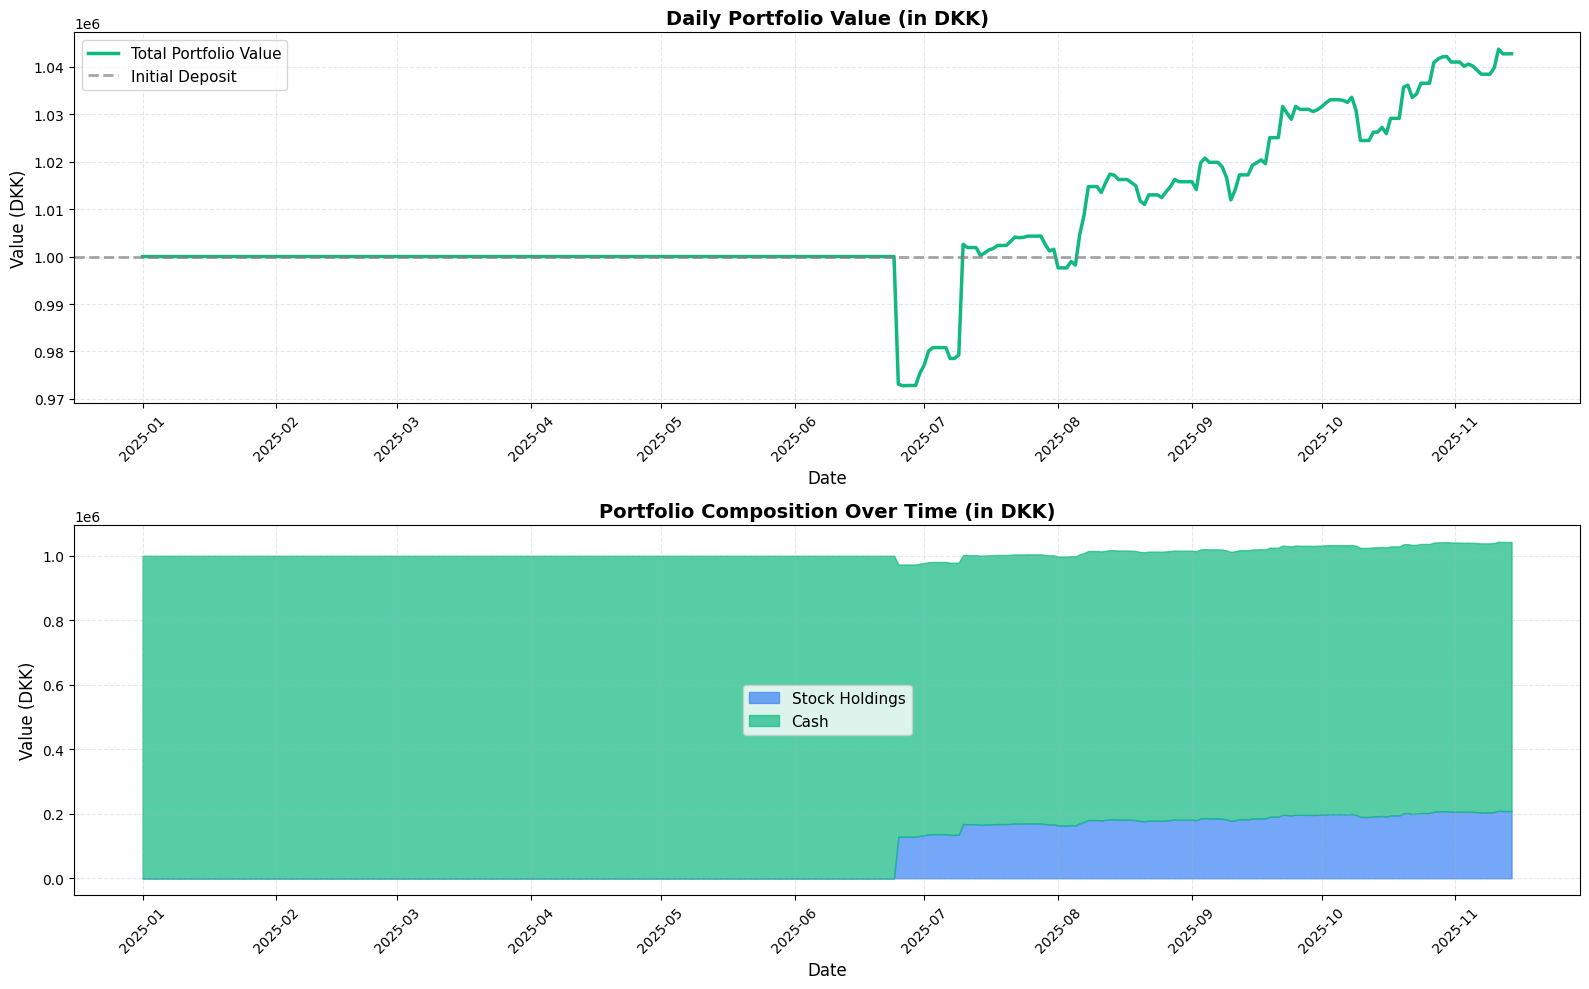


✓ Daily portfolio development charts displayed above


In [14]:
# Cell 12: Daily Portfolio Development
if portfolio_config is None:
    print("Please create a portfolio configuration first (Cell 4)")
elif transactions.empty:
    print("No transactions to analyze")
else:
    print("Calculating daily portfolio development...")
    print("This may take a moment as we fetch historical prices...\n")
    
    # Get date range
    start_date = pd.to_datetime(portfolio_config['start_date'])
    end_date = pd.to_datetime(datetime.now().strftime('%Y-%m-%d'))
    
    # Get all unique tickers that have been traded
    all_tickers = transactions[transactions['action'].isin(['buy', 'sell'])]['ticker'].unique()
    
    if len(all_tickers) == 0:
        print("No stock transactions found")
    else:
        # Fetch historical prices
        print("Fetching historical prices...")
        historical_prices = get_historical_prices(all_tickers, start_date)
        
        # Create date range
        date_range = pd.date_range(start=start_date, end=end_date, freq='D')
        
        daily_values = []
        
        for current_date in date_range:
            date_str = current_date.strftime('%Y-%m-%d')
            
            # Get holdings at this date
            holdings = calculate_holdings_at_date(transactions, date_str)
            
            # Calculate portfolio value
            stock_value = 0
            
            for ticker, holding in holdings.items():
                if ticker in historical_prices and historical_prices[ticker] is not None:
                    # Get price for this date or closest previous date
                    ticker_prices = historical_prices[ticker]
                    # Convert current_date to timezone-aware to match historical prices index
                    current_date_tz = current_date.tz_localize('America/New_York')
                    available_dates = ticker_prices.index[ticker_prices.index <= current_date_tz]
                    
                    if len(available_dates) > 0:
                        print(price_date)
                        price_date = available_dates[-1]
                        price = ticker_prices[price_date]
                        
                        rate = get_exchange_rate(holding['currency'])
                        value_dkk = holding['quantity'] * price * rate
                        stock_value += value_dkk
            
            # Calculate cash at this date
            transactions_to_date = transactions[pd.to_datetime(transactions['date']) <= current_date]
            if len(transactions_to_date) > 0:
                # Recalculate cash for this specific date
                rate = get_exchange_rate(portfolio_config['currency'])
                cash = portfolio_config['initial_deposit'] * rate
                
                for _, row in transactions_to_date.iterrows():
                    trans_rate = get_exchange_rate(row['currency'])
                    if row['action'] == 'buy':
                        cash -= row['quantity'] * row['price'] * trans_rate
                    elif row['action'] == 'sell':
                        cash += row['quantity'] * row['price'] * trans_rate
                    elif row['action'] == 'dividend':
                        dividend_amt = row.get('dividend_amount', 0)
                        if pd.notna(dividend_amt):
                            cash += dividend_amt * trans_rate
            else:
                rate = get_exchange_rate(portfolio_config['currency'])
                cash = portfolio_config['initial_deposit'] * rate
            
            total_value = stock_value + cash
            
            daily_values.append({
                'date': current_date,
                'stock_value': stock_value,
                'cash': cash,
                'total_value': total_value
            })
        
        daily_df = pd.DataFrame(daily_values)
        
        print(f"\n✓ Calculated {len(daily_df)} days of portfolio data")
        print("\nLatest portfolio values:")
        display(daily_df.tail(10))
        
        # Plot daily development
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))
        
        # Plot 1: Total portfolio value
        ax1.plot(daily_df['date'], daily_df['total_value'], linewidth=2.5, 
                label='Total Portfolio Value', color='#10b981', marker='')
        
        # Add initial deposit line
        rate = get_exchange_rate(portfolio_config['currency'])
        initial_deposit_dkk = portfolio_config['initial_deposit'] * rate
        ax1.axhline(y=initial_deposit_dkk, color='gray', linestyle='--', 
                   linewidth=2, alpha=0.7, label='Initial Deposit')
        
        ax1.set_xlabel('Date', fontsize=12)
        ax1.set_ylabel(f'Value ({BASE_CURRENCY})', fontsize=12)
        ax1.set_title(f'Daily Portfolio Value (in {BASE_CURRENCY})', fontsize=14, fontweight='bold')
        ax1.legend(fontsize=11)
        ax1.grid(True, alpha=0.3, linestyle='--')
        ax1.tick_params(axis='x', rotation=45)
        
        # Plot 2: Breakdown - Stocks vs Cash
        ax2.fill_between(daily_df['date'], 0, daily_df['stock_value'], 
                        label='Stock Holdings', alpha=0.7, color='#3b82f6')
        ax2.fill_between(daily_df['date'], daily_df['stock_value'], 
                        daily_df['total_value'], 
                        label='Cash', alpha=0.7, color='#10b981')
        
        ax2.set_xlabel('Date', fontsize=12)
        ax2.set_ylabel(f'Value ({BASE_CURRENCY})', fontsize=12)
        ax2.set_title(f'Portfolio Composition Over Time (in {BASE_CURRENCY})', 
                     fontsize=14, fontweight='bold')
        ax2.legend(fontsize=11)
        ax2.grid(True, alpha=0.3, linestyle='--')
        ax2.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
        
        print("\n✓ Daily portfolio development charts displayed above")


In [15]:
# Cell 13: Portfolio Statistics Table (by Week/Month)
if portfolio_config is None or 'daily_df' not in locals():
    print("Please run Cell 12 first to calculate daily portfolio values")
else:
    print("📊 Portfolio Performance Summary\n")
    
    # Weekly summary
    daily_df['week'] = daily_df['date'].dt.to_period('W')
    weekly_df = daily_df.groupby('week').agg({
        'total_value': 'last',
        'stock_value': 'last',
        'cash': 'last'
    }).reset_index()
    weekly_df['week'] = weekly_df['week'].astype(str)
    
    # Calculate weekly returns
    weekly_df['return'] = weekly_df['total_value'].pct_change() * 100
    weekly_df['return'] = weekly_df['return'].fillna(0)
    
    print("📅 Weekly Portfolio Values (Last 10 weeks):")
    display(weekly_df.tail(10))
    
    # Monthly summary
    daily_df['month'] = daily_df['date'].dt.to_period('M')
    monthly_df = daily_df.groupby('month').agg({
        'total_value': 'last',
        'stock_value': 'last',
        'cash': 'last'
    }).reset_index()
    monthly_df['month'] = monthly_df['month'].astype(str)
    
    # Calculate monthly returns
    monthly_df['return'] = monthly_df['total_value'].pct_change() * 100
    monthly_df['return'] = monthly_df['return'].fillna(0)
    
    print("\n📅 Monthly Portfolio Values:")
    display(monthly_df)
    
    # Overall statistics
    rate = get_exchange_rate(portfolio_config['currency'])
    initial_deposit_dkk = portfolio_config['initial_deposit'] * rate
    final_value = daily_df['total_value'].iloc[-1]
    total_return = final_value - initial_deposit_dkk
    total_return_pct = (total_return / initial_deposit_dkk * 100)
    
    # Calculate number of days
    num_days = (daily_df['date'].iloc[-1] - daily_df['date'].iloc[0]).days
    annualized_return = (((final_value / initial_deposit_dkk) ** (365 / num_days)) - 1) * 100 if num_days > 0 else 0
    
    print(f"\n{'='*80}")
    print(f"📈 OVERALL PERFORMANCE STATISTICS")
    print(f"{'='*80}")
    print(f"Start Date:               {portfolio_config['start_date']}")
    print(f"Days Active:              {num_days}")
    print(f"Initial Deposit:          {initial_deposit_dkk:,.2f} {BASE_CURRENCY}")
    print(f"Current Value:            {final_value:,.2f} {BASE_CURRENCY}")
    print(f"Total Return:             {total_return:+,.2f} {BASE_CURRENCY} ({total_return_pct:+.2f}%)")
    print(f"Annualized Return:        {annualized_return:+.2f}%")
    print(f"{'='*80}")

📊 Portfolio Performance Summary

📅 Weekly Portfolio Values (Last 10 weeks):


,week,total_value,stock_value,cash,return
36,2025-09-08/2025-09-14,1.017227e+06,182862.992816,834364.0,-0.259636
37,2025-09-15/2025-09-21,1.025073e+06,190709.462036,834364.0,0.771359
38,2025-09-22/2025-09-28,1.031046e+06,196682.221106,834364.0,0.582666
39,2025-09-29/2025-10-05,1.033066e+06,198702.279749,834364.0,0.195923
40,2025-10-06/2025-10-12,1.024478e+06,190114.477643,834364.0,-0.831292
41,2025-10-13/2025-10-19,1.029149e+06,194785.147156,834364.0,0.455907
42,2025-10-20/2025-10-26,1.036547e+06,202182.806104,834364.0,0.718813
43,2025-10-27/2025-11-02,1.041017e+06,206652.836902,834364.0,0.431243
44,2025-11-03/2025-11-09,1.038451e+06,204086.658984,834364.0,-0.246507
45,2025-11-10/2025-11-16,1.042772e+06,208407.651270,834364.0,0.416100



📅 Monthly Portfolio Values:


,month,total_value,stock_value,cash,return
0,2025-01,1.000000e+06,0.000000,1000000.0,0.000000
1,2025-02,1.000000e+06,0.000000,1000000.0,0.000000
2,2025-03,1.000000e+06,0.000000,1000000.0,0.000000
3,2025-04,1.000000e+06,0.000000,1000000.0,0.000000
4,2025-05,1.000000e+06,0.000000,1000000.0,0.000000
5,2025-06,9.754364e+05,131442.397797,843994.0,-2.456360
6,2025-07,1.001538e+06,167174.456763,834364.0,2.675937
7,2025-08,1.015783e+06,181419.041400,834364.0,1.422270
8,2025-09,1.030931e+06,196566.538458,834364.0,1.491214
9,2025-10,1.041017e+06,206652.836902,834364.0,0.978368



📈 OVERALL PERFORMANCE STATISTICS
Start Date:               2025-01-01
Days Active:              317
Initial Deposit:          1,000,000.00 DKK
Current Value:            1,042,771.65 DKK
Total Return:             +42,771.65 DKK (+4.28%)
Annualized Return:        +4.94%


In [16]:
# Cell 14: Export Daily Portfolio Data
if 'daily_df' in locals():
    # Export to CSV
    daily_df.to_csv('daily_portfolio_values.csv', index=False)
    print("✓ Daily portfolio values exported to 'daily_portfolio_values.csv'")
    
    # Create detailed report
    report_date = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    
    with open('portfolio_report_detailed.txt', 'w', encoding='utf-8') as f:
        f.write("="*80 + "\n")
        f.write(f"DETAILED PORTFOLIO REPORT\n")
        f.write(f"Generated: {report_date}\n")
        f.write(f"Base Currency: {BASE_CURRENCY}\n")
        f.write("="*80 + "\n\n")
        
        f.write(f"Portfolio Configuration:\n")
        f.write(f"  Start Date: {portfolio_config['start_date']}\n")
        f.write(f"  Initial Deposit: {portfolio_config['initial_deposit']} {portfolio_config['currency']}\n\n")
        
        rate = get_exchange_rate(portfolio_config['currency'])
        initial_deposit_dkk = portfolio_config['initial_deposit'] * rate
        final_value = daily_df['total_value'].iloc[-1]
        total_return = final_value - initial_deposit_dkk
        total_return_pct = (total_return / initial_deposit_dkk * 100)
        
        f.write(f"Current Portfolio Status:\n")
        f.write(f"  Total Value: {final_value:,.2f} {BASE_CURRENCY}\n")
        f.write(f"  Stock Holdings: {daily_df['stock_value'].iloc[-1]:,.2f} {BASE_CURRENCY}\n")
        f.write(f"  Cash: {daily_df['cash'].iloc[-1]:,.2f} {BASE_CURRENCY}\n")
        f.write(f"  Total Return: {total_return:+,.2f} {BASE_CURRENCY} ({total_return_pct:+.2f}%)\n\n")
        
        f.write("="*80 + "\n")
        f.write("TRANSACTION HISTORY\n")
        f.write("="*80 + "\n")
        f.write(transactions.to_string(index=False))
        f.write("\n\n")
        
        f.write("="*80 + "\n")
        f.write("MONTHLY PERFORMANCE\n")
        f.write("="*80 + "\n")
        f.write(monthly_df.to_string(index=False))
    
    print("✓ Detailed portfolio report exported to 'portfolio_report_detailed.txt'")
else:
    print("Please run Cell 12 first to generate portfolio data")

✓ Daily portfolio values exported to 'daily_portfolio_values.csv'
✓ Detailed portfolio report exported to 'portfolio_report_detailed.txt'
